# 03 - Sportstaetten pro Bezirk

**Ziel:** Ermittelt Sportinfrastruktur-Indikatoren pro Stadtbezirk auf OSM-Basis.

**Inputs:** data/interim/muc_bezirke_bev_clean.geojson, OSM-Sportstaetten

**Outputs:** data/processed/muc_bezirke_sport.geojson

**Ausfuehrung:** Von oben nach unten ausfuehren (Restart & Run All). Dieses Notebook ist Teil der Pipeline 00 -> 05.


## Setup

In [1]:
import geopandas as gpd
import osmnx as ox
from pathlib import Path
import matplotlib.pyplot as plt

BASE_DIR = Path("..")
INTERIM_DIR = BASE_DIR / "data" / "interim"
PROCESSED_DIR = BASE_DIR / "data" / "processed"

## Daten laden


### Bezirk DF laden

In [3]:
# Basis: Stadtbezirke laden
gdf_bezirke = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")
gdf_bezirke = gdf_bezirke.sort_values("bez_nr").reset_index(drop=True)
gdf_bezirke.head()


,bez_nr,name,stadtbezirk,einwohner,flaeche_ha,einwohnerdichte,geometry
0,1,Altstadt-Lehel,Altstadt - Lehel,20876,314.59,66.0,"POLYGON ((692704.77 5336941.154, 692682.921 53..."
1,2,Ludwigsvorstadt-Isarvorstadt,Ludwigsvorstadt - Isarvorstadt,50081,440.17,114.0,"POLYGON ((689722.841 5335359.37, 689570.385 53..."
2,3,Maxvorstadt,Maxvorstadt,52434,429.82,122.0,"POLYGON ((690674.877 5336921.715, 690657.282 5..."
3,4,Schwabing-West,Schwabing West,68610,436.33,157.0,"POLYGON ((691821.837 5339259.125, 691767.291 5..."
4,5,Au-Haidhausen,Au - Haidhausen,63972,422.00,152.0,"POLYGON ((693021.981 5335306.773, 693021.084 5..."


### Sportstätten aus OpenStreetMap laden

In [4]:
place_name = "München, Deutschland"
sport_tags = {"leisure": ["sports_centre", "pitch"]}

gdf_sport = ox.features_from_place(place_name, sport_tags)

# CRS an Bezirkslayer anpassen
gdf_sport = gdf_sport.to_crs(gdf_bezirke.crs)

gdf_sport[["name", "leisure", "geometry"]].head(), len(gdf_sport)


(                  name leisure                        geometry
 element id                                                    
 node    243362188  NaN   pitch  POINT (690314.641 5336477.563)
         243362189  NaN   pitch  POINT (690322.001 5336469.374)
         257546774  NaN   pitch   POINT (696642.61 5332213.561)
         257547095  NaN   pitch  POINT (696720.228 5332172.622)
         266620278  NaN   pitch  POINT (693115.155 5333174.542),
 2570)

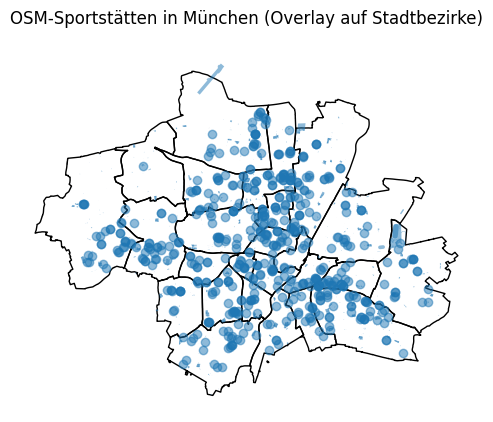

In [5]:
ax = gdf_bezirke.plot(edgecolor="black", facecolor="none", figsize=(6, 6))
gdf_sport.plot(ax=ax, alpha=0.5)
plt.title("OSM-Sportstätten in München (Overlay auf Stadtbezirke)")
plt.axis("off")
plt.show()


## Preparation

### Räumliche Zuordnung der Sportstätten zu Stadtbezirken

In [6]:
sports = gdf_sport[["name", "leisure", "geometry"]].copy()

sports_in_bezirke = gpd.sjoin(
    sports,
    gdf_bezirke[["bez_nr", "geometry"]],
    how="inner",
    predicate="intersects",
)

sports_in_bezirke[["name", "leisure", "bez_nr"]].head(10)


name        leisure  bez_nr
element id                                                            
node    243362188                           NaN          pitch       3
        243362189                           NaN          pitch       3
        257546774                           NaN          pitch      16
        257547095                           NaN          pitch      16
        266620278                           NaN          pitch       5
        291898679               boxt euch durch  sports_centre       1
        292910956                   Boulesplatz          pitch       1
        292969966   Fitness-Studio Arabellapark  sports_centre      13
        295850818                           NaN          pitch      12
        319075477  Skyfit Women München-Giesing  sports_centre      16

### Aggregation auf Bezirksebene & Ableitung von Sportstätten-Kennzahlen

In [7]:
# Anzahl Sportstätten pro Bezirk
sports_per_bez = (
    sports_in_bezirke
    .groupby("bez_nr")
    .size()
    .reset_index(name="sports_count")
)

# Fläche der Sportstätten (wenn Geometrien Flächen sind – sonst kann man Fläche zunächst als optionales Feature sehen)
sports_in_bezirke["sports_area"] = sports_in_bezirke.geometry.area

sports_area_per_bez = (
    sports_in_bezirke
    .groupby("bez_nr")["sports_area"]
    .sum()
    .reset_index()
)

sports_area_per_bez["sports_area_ha"] = sports_area_per_bez["sports_area"] / 10_000
sports_area_per_bez = sports_area_per_bez[["bez_nr", "sports_area_ha"]]

# Mit Bezirksdaten mergen
gdf_sport_active = gdf_bezirke.merge(sports_per_bez, on="bez_nr", how="left")
gdf_sport_active = gdf_sport_active.merge(sports_area_per_bez, on="bez_nr", how="left")

# Bezirke ohne Sportstätten: NAs auf 0
gdf_sport_active[["sports_count", "sports_area_ha"]] = (
    gdf_sport_active[["sports_count", "sports_area_ha"]].fillna(0)
)

# Kennzahlen
gdf_sport_active["sports_pro_1000_einw"] = (
    gdf_sport_active["sports_count"] / gdf_sport_active["einwohner"] * 1000
)
gdf_sport_active["sports_area_ha_pro_1000_einw"] = (
    gdf_sport_active["sports_area_ha"] / gdf_sport_active["einwohner"] * 1000
)
gdf_sport_active["sports_area_anteil_prozent"] = (
    gdf_sport_active["sports_area_ha"] / gdf_sport_active["flaeche_ha"] * 100
)

gdf_sport_active[[
    "bez_nr", "name", "sports_count", "sports_area_ha",
    "sports_pro_1000_einw", "sports_area_anteil_prozent"
]].head()


,bez_nr,name,sports_count,sports_area_ha,sports_pro_1000_einw,sports_area_anteil_prozent
0,1,Altstadt-Lehel,19,3.843882,0.910136,1.221870
1,2,Ludwigsvorstadt-Isarvorstadt,37,1.203739,0.738803,0.273471
2,3,Maxvorstadt,45,1.081920,0.858222,0.251715
3,4,Schwabing-West,56,6.817058,0.816208,1.562363
4,5,Au-Haidhausen,66,10.829776,1.031701,2.566298


## Analyse der Kennzahlen

### Räumliche Verteilung: Sportstätten pro 1.000 Einwohner

Im ersten Schritt wird betrachtet, wie viele Sportstätten pro 1.000 Einwohner in den
einzelnen Stadtbezirken zur Verfügung stehen.

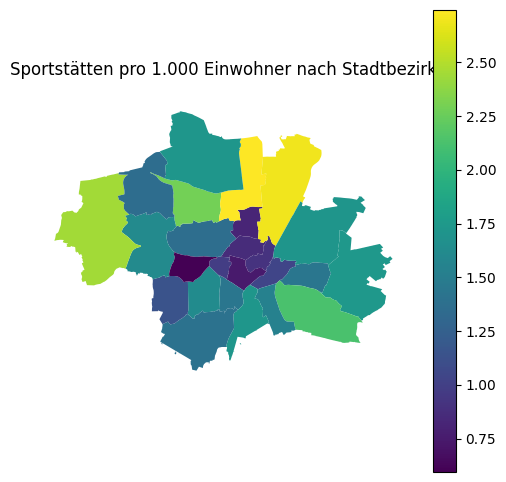

In [8]:
gdf_sport_active.plot(
    column="sports_pro_1000_einw",
    legend=True,
    figsize=(6, 6)
)
plt.title("Sportstätten pro 1.000 Einwohner nach Stadtbezirk")
plt.axis("off")
plt.show()


**Interpretation:**

- Die Versorgung mit Sportstätten pro 1.000 Einwohner ist räumlich ungleich verteilt:
  einige Stadtbezirke erreichen deutlich höhere Werte als andere.
- Erste Cluster sind erkennbar: bestimmte Bezirke weisen eine vergleichsweise hohe
  Dichte an Sportstätten pro Einwohner auf, während andere Bezirke deutlich weniger
  Angebote pro Kopf haben.
- Diese Kennzahl ergänzt die Park-Analyse und zeigt, in welchen Bezirken neben
  Grünflächen auch sportbezogene Infrastruktur besonders gut bzw. eher schwach
  ausgeprägt ist.

### Verteilung: Sportstätten pro 1.000 Einwohner

Die folgende Abbildung zeigt Histogramm und Boxplot der Kennzahl
`sports_pro_1000_einw` über alle Stadtbezirke.

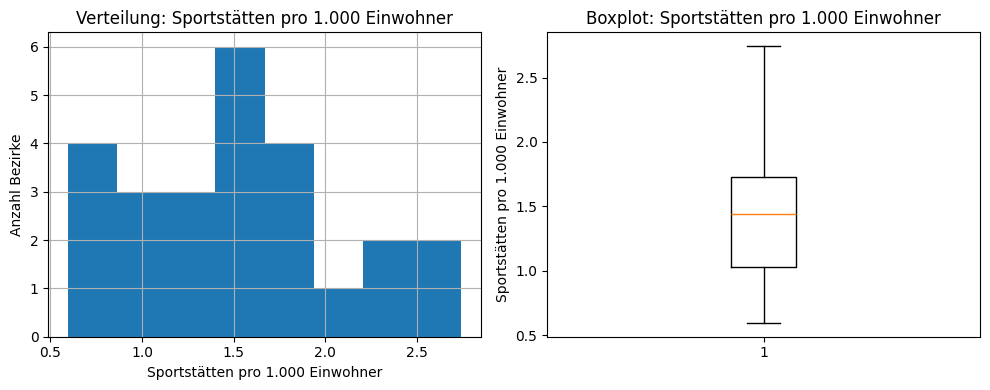

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogramm
gdf_sport_active["sports_pro_1000_einw"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Sportstätten pro 1.000 Einwohner")
axes[0].set_xlabel("Sportstätten pro 1.000 Einwohner")
axes[0].set_ylabel("Anzahl Bezirke")

# Boxplot
axes[1].boxplot(gdf_sport_active["sports_pro_1000_einw"], vert=True)
axes[1].set_title("Boxplot: Sportstätten pro 1.000 Einwohner")
axes[1].set_ylabel("Sportstätten pro 1.000 Einwohner")

plt.tight_layout()
plt.show()


**Interpretation:**

- Die meisten Stadtbezirke liegen in einem mittleren Bereich von `sports_pro_1000_einw`
  (z. B. etwa zwischen x und y Sportstätten pro 1.000 Einwohner).
- Einige Bezirke bilden obere bzw. untere Ausreißer und sind damit deutlich besser
  bzw. schlechter mit Sportstätten pro Kopf versorgt.
- Insgesamt bestätigt die Verteilung, dass es deutliche Unterschiede in der sportbezogenen
  Infrastruktur zwischen den Stadtbezirken gibt.

### Verteilung: Anteil der Sportflächen an der Bezirksfläche

Zusätzlich wird der prozentuale Anteil der Sportflächen an der Gesamtfläche
des jeweiligen Stadtbezirks (`sports_area_anteil_prozent`) betrachtet.

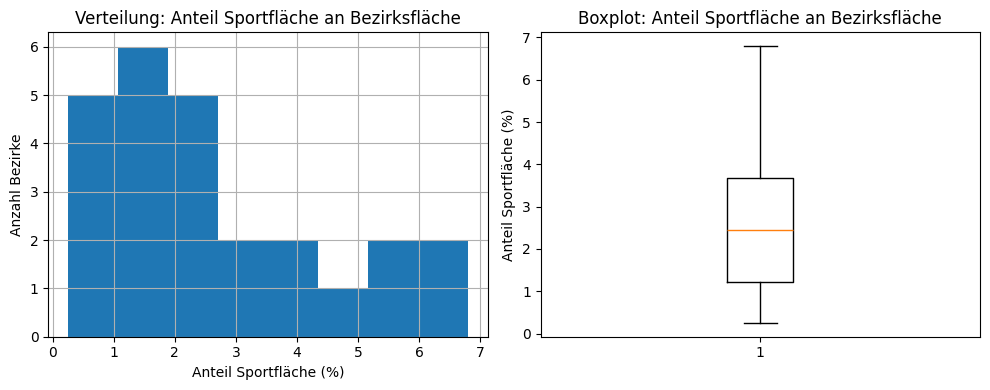

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogramm
gdf_sport_active["sports_area_anteil_prozent"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Anteil Sportfläche an Bezirksfläche")
axes[0].set_xlabel("Anteil Sportfläche (%)")
axes[0].set_ylabel("Anzahl Bezirke")

# Boxplot
axes[1].boxplot(gdf_sport_active["sports_area_anteil_prozent"], vert=True)
axes[1].set_title("Boxplot: Anteil Sportfläche an Bezirksfläche")
axes[1].set_ylabel("Anteil Sportfläche (%)")

plt.tight_layout()
plt.show()


### Ranking: Top- und Bottom-Bezirke


Zur Einordnung werden die Stadtbezirke nach der Kennzahl `sports_pro_1000_einw`
sortiert. Die Top-5- und Bottom-5-Bezirke werden als horizontale Balkendiagramme
dargestellt.

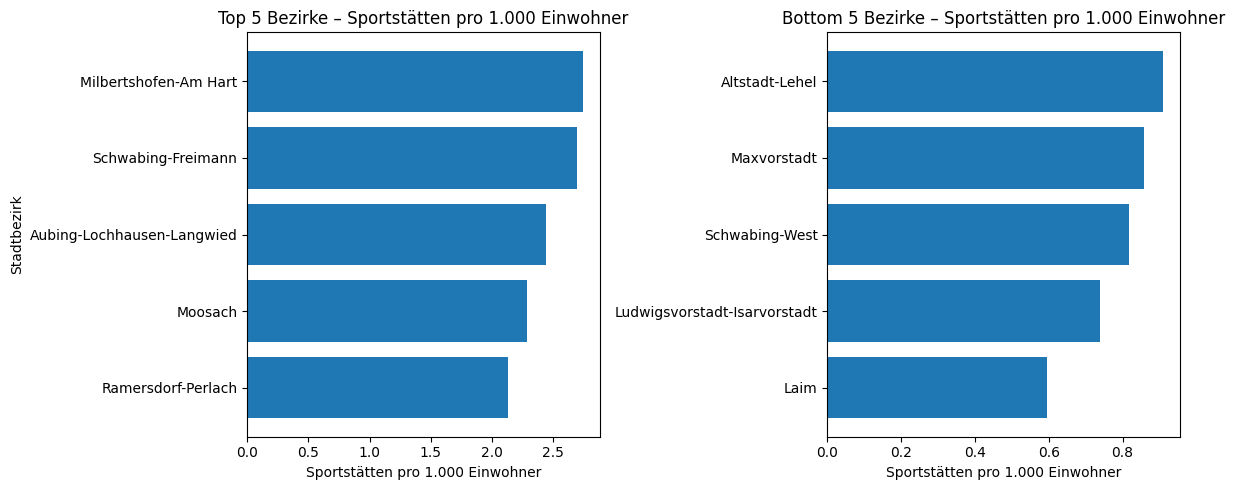

In [11]:
# Top 5
top5_sport = (
    gdf_sport_active[["name", "sports_pro_1000_einw"]]
    .sort_values("sports_pro_1000_einw", ascending=False)
    .head(5)
    .sort_values("sports_pro_1000_einw", ascending=True)  # für schöne Treppe bei barh
)

# Bottom 5
bottom5_sport = (
    gdf_sport_active[["name", "sports_pro_1000_einw"]]
    .sort_values("sports_pro_1000_einw", ascending=True)
    .head(5)
    .sort_values("sports_pro_1000_einw", ascending=True)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Top 5
axes[0].barh(top5_sport["name"], top5_sport["sports_pro_1000_einw"])
axes[0].set_title("Top 5 Bezirke – Sportstätten pro 1.000 Einwohner")
axes[0].set_xlabel("Sportstätten pro 1.000 Einwohner")
axes[0].set_ylabel("Stadtbezirk")

# Bottom 5
axes[1].barh(bottom5_sport["name"], bottom5_sport["sports_pro_1000_einw"])
axes[1].set_title("Bottom 5 Bezirke – Sportstätten pro 1.000 Einwohner")
axes[1].set_xlabel("Sportstätten pro 1.000 Einwohner")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


**Interpretation:**

- Die Top-5-Stadtbezirke verfügen über deutlich mehr Sportstätten pro 1.000 Einwohner
  als der Durchschnitt und können als besonders gut versorgt gelten.
- Die Bottom-5-Stadtbezirke liegen klar unterhalb des Mittelwerts; hier stehen deutlich
  weniger Sportstätten pro Kopf zur Verfügung.
- Im Zusammenspiel mit den Park-Kennzahlen lassen sich später Bezirke identifizieren,
  die sowohl bei Grünflächen als auch bei Sportinfrastruktur unter- bzw. überdurchschnittlich
  abschneiden.


In diesem Notebook wurden die Münchner Stadtbezirke um sportbezogene Kennzahlen
erweitert. Analog zum Parks-Notebook liegen nun für jeden Bezirk u. a. die Anzahl
der Sportstätten, die gesamte Sportfläche, Sportstätten pro 1.000 Einwohner und der
Anteil der Sportflächen an der Bezirksfläche vor. Erste Karten, Verteilungen und
Rankings zeigen deutliche räumliche Unterschiede in der Versorgung mit Sportangeboten.
Diese Kennzahlen werden im weiteren Projekt mit den Park-Indikatoren kombiniert,
um ein umfassenderes Bild der „Aktivitätsfreundlichkeit“ der Stadtbezirke zu erhalten.

## Export des erweiterten Datensatzes

In [12]:
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
out_path = PROCESSED_DIR / "muc_bezirke_sport.geojson"
gdf_sport_active.to_file(out_path, driver="GeoJSON")
out_path


PosixPath('../data/processed/muc_bezirke_sport.geojson')